In [11]:
# Fitting volatility to make art, an overkill approach...

## Code forked from @author: cantaro86, they have built a great repo please check it out!
## Wanted to say thank you to Professor Riaz Ahmed @ UCL for inspiring us. "Hamza is asking another stats question today"
## Adapted by Hamza & Parth

import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

!pip install Cython
!pip install arch

from arch.unitroot import PhillipsPerron, KPSS, ADF
from arch import arch_model
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import pacf
import matplotlib.gridspec as gridspec
from scipy.integrate import quad
from scipy.optimize import minimize

from time import time
import scipy as scp
import scipy.stats as ss

import matplotlib.cm as cm
import matplotlib as mpl
from cycler import cycler

In [2]:
# Heston model

np.random.seed(seed=42) 
N = 2500            # time steps 
paths = 2              # number of paths
T = 1
T_vec,dt = np.linspace(0,T,N, retstep=True )
dt_sq = np.sqrt(dt)

s0 = 100          # spot price
v0 = 0.04         # spot variance

mu = 0.1 # drift
rho = -0.2 # correlation coefficient
kappa = 2 # mean reversion coefficient
theta = 0.04  # long-term variance
sigma = 0.3  # Volatility of inst. variance
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) ) # asymptotic standard deviation for the CIR process
assert(2*kappa * theta > sigma**2)   # Feller condition

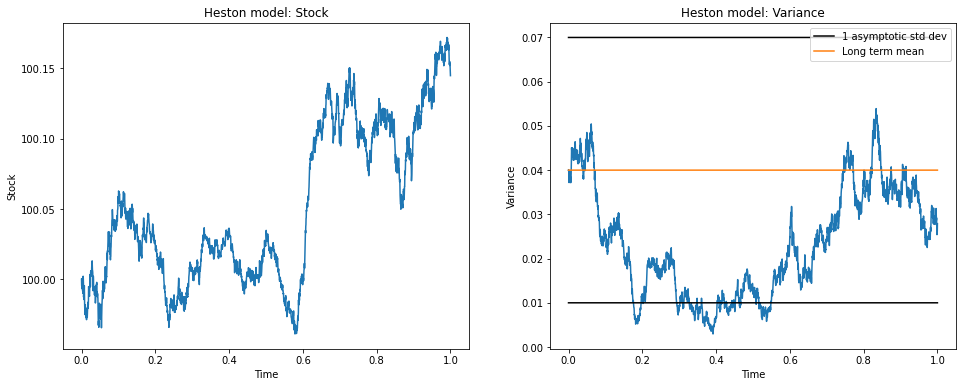

In [3]:
# Hestom Model: Same code the Heston Watercolor notebook
## page number 145 : Tools from Stochastic Analysis for Mathematical Finance: A Gentle Introduction

# Paths

np.random.seed(seed=42)
# Generate Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = ss.multivariate_normal.rvs( mean=MU, cov=COV, size=(paths,N-1) )
W_S = W[:,:,0]   # Stock Brownian motion:     W_1
W_v = W[:,:,1]   # Variance Brownian motion:  W_2

# Initialize vectors
V = np.zeros((paths,N))
V[:,0] = v0
S = np.zeros((paths,N))
S[:,0] = s0
v = np.zeros(N)

# Generate paths
for t in range(0,N-1):
    v = V[:,t]            # variance 
    v_sq = np.sqrt(v)     # square root of variance 
    
    V[:,t+1] = V[:,t] + (kappa*(theta-v))*dt + sigma*(v_sq)*dt_sq*W_v[:,t]   
    S[:,t+1] = S[:,t] + (mu-0.5*v)*dt + v_sq*dt_sq*W_S[:,t]
    
S = S.T[:,1]  # just using one path for simplicity. 
V = V.T[:,1]

ret_log = np.log(S[1:]/S[:-1])        # log returns (makes it stationary for the GARCH)
#np.shape(ret_log)

fig = plt.figure(figsize=(16,6))
plot1 = fig.add_subplot(121); plot2 = fig.add_subplot(122)

plot1.plot(T_vec,S)
plot1.set_title("Heston model: Stock"); plot1.set_xlabel("Time"); plot1.set_ylabel("Stock")

plot2.plot(T_vec,V)
plot2.set_title("Heston model: Variance"); plot2.set_xlabel("Time"); plot2.set_ylabel("Variance")
plot2.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
plot2.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
plot2.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
plot2.legend(loc="upper right")

plt.show()

#plt.plot(ret_log)

#plt.plot(S)

In [7]:
train_size = 2000
train = ret_log[:train_size]
train = train - train.mean()            # demean the series   
test = ret_log[train_size:]



(<class 'statsmodels.iolib.summary.Summary'>
 """
                        Zero Mean - GARCH Model Results                        
 Dep. Variable:                      y   R-squared:                       0.000
 Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
 Vol Model:                      GARCH   Log-Likelihood:                4311.44
 Distribution:                  Normal   AIC:                          -8616.89
 Method:            Maximum Likelihood   BIC:                          -8600.08
                                         No. Observations:                 2000
 Date:                Tue, Jan 19 2021   Df Residuals:                     1997
 Time:                        19:40:58   Df Model:                            3
                               Volatility Model                              
                  coef    std err          t      P>|t|      95.0% Conf. Int.
 -------------------------------------------------------------------------

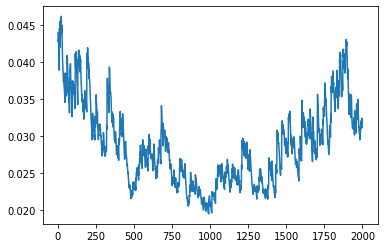

In [8]:
# GARCH(1,1) on the training data

# manual scale
scaler = 1000
garch = arch_model(scaler*train, mean='zero', vol='GARCH', p=1 ,q=1, rescale=False)

res = garch.fit(disp='off')  


res.summary(),plt.plot(res.conditional_volatility)


# Conf int for omega contains a small negative, for the purposes of this project, we have left the result as is.

(<class 'statsmodels.iolib.summary.Summary'>
 """
                        Zero Mean - GARCH Model Results                        
 Dep. Variable:                      y   R-squared:                       0.000
 Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
 Vol Model:                      GARCH   Log-Likelihood:                953.035
 Distribution:                  Normal   AIC:                          -1900.07
 Method:            Maximum Likelihood   BIC:                          -1887.43
                                         No. Observations:                  499
 Date:                Tue, Jan 19 2021   Df Residuals:                      496
 Time:                        19:40:59   Df Model:                            3
                                Volatility Model                              
                  coef    std err          t      P>|t|       95.0% Conf. Int.
 -----------------------------------------------------------------------

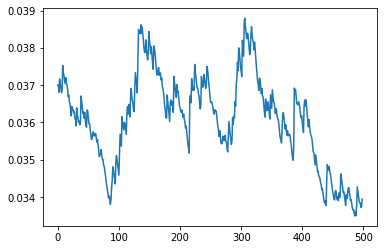

In [9]:
# GARCH(1,1) on the test data
## out of sample estimation
## this isnt needed for the art

garchTest = arch_model(scaler*test, mean='zero', vol='GARCH', p=1 ,q=1, rescale=False)

resTest = garchTest.fit(disp='off')  

resTest.summary(),plt.plot(resTest.conditional_volatility)
#plt.plot(resTest.resid)
# # Conf int for omega contains a small negative, for the purposes of this project, we have left the result as is.

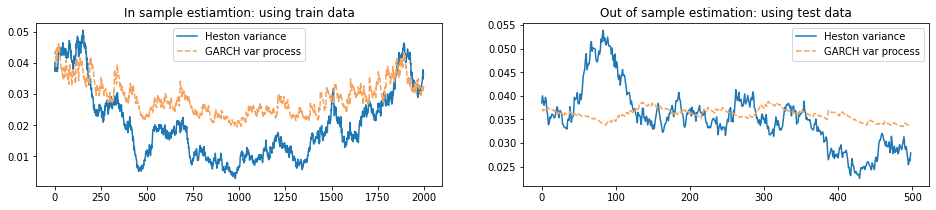

In [10]:
fig = plt.figure(figsize=(16,3))

ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

GvarTrain = (res.conditional_volatility)
GvarTest = (resTest.conditional_volatility)
ax1.plot(V[1:train_size], label="Heston variance"); ax2.plot(V[1+train_size:], label="Heston variance")

ax1.plot(GvarTrain, label="GARCH var process", color='sandybrown', linestyle='--')
ax2.plot(GvarTest, label="GARCH var process", color='sandybrown', linestyle='--')

ax1.set_title("In sample estiamtion: using train data"); ax2.set_title("Out of sample estimation: using test data")
ax1.legend();ax2.legend(); 
plt.show()

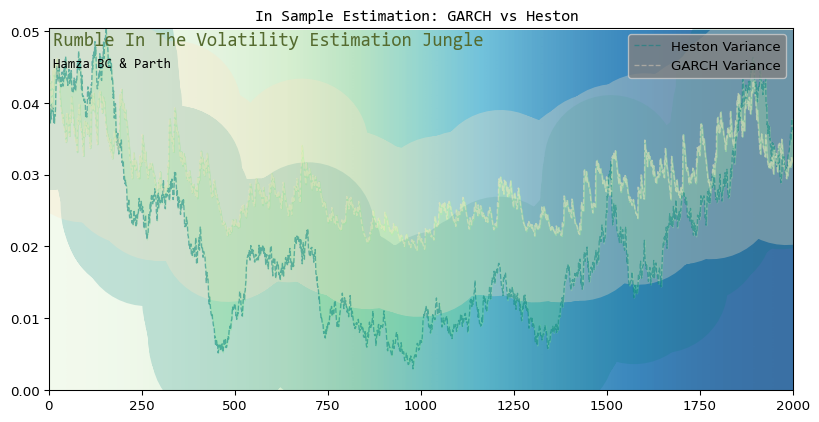

In [155]:
# Let there be art!

grad = [[0, 1], [0, 1]]
xl = 0
xh = 2000
yl = 0
yh = 0.05


heston = V[0:train_size]
minVal = np.minimum(heston, GvarTrain)
maxVal = np.maximum(GvarTrain,heston)
xVal = range(train_size)

plt.figure(figsize=(10,5),dpi=96)
hfont = {'fontname':'Consolas'}

plt.margins(0)

plt.title("In Sample Estimation: GARCH vs Heston ",**hfont)

plt.imshow(grad,  cmap = cm.GnBu, interpolation = "bicubic", extent = [xl, xh, yl, yh],alpha = .8, aspect = "auto")


plt.plot(xVal,heston,linewidth=100,alpha=0.2,color='teal')
plt.plot(xVal,GvarTrain,linewidth=100,alpha=0.3,color='bisque')
plt.plot(xVal,heston,linewidth=1,alpha=0.5,color='teal',label='Heston Variance',linestyle='--')
plt.plot(xVal,GvarTrain,linewidth=1,alpha=0.4,color='bisque',label='GARCH Variance',linestyle='--')

plt.fill_between(xVal,GvarTrain,minVal ,color='palegreen',alpha=0.3)
plt.fill_between(xVal,GvarTrain,maxVal ,color='palegreen',alpha=0.3)

plt.legend(facecolor='grey',loc='upper right')


plt.text(10, 0.048, "Rumble In The Volatility Estimation Jungle",**hfont,fontsize=14,color="darkolivegreen")
plt.text(10, 0.045, "Hamza BC & Parth",**hfont,color="black")

plt.show()

